## Multiscale latents 

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import gym
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import defaultdict
import os, sys
root = os.getcwd()
sys.path.append(root)
sys.path.append('..')

import matplotlib as mpl
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['font.size'] = 8
# mpl.rcParams['font.family'] = 'serif'
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

import utils.plot_utils as pltu
from logger import *
from utils.plot_utils import *
from plot_functions import *
from configs import *
from models.model_lstm import *
# import tasks.generative_1d
from tasks.hierarchical_gaussians_task import *
from train import *
# from plot_functions import plot_behavior_novel_contexts, plot_histograms_novel_contexts
# from plot_functions import plot_combined_behavior_and_histograms
from plot_functions import *

default_mean1 = 0.3
default_mean2 = 0.7
default_std = 0.1
default_std_novel = 0.2
means = np.array(list(range(-2, 13)))/10
stds = [0.1, 0.2, 0.3, 0.4, 0.5]


# Z1 Z2!

In [3]:
# Initiate and maybe Train RNN 
train_model = False
# horizon_long_short = 'short'
horizon_long_short = 'long'
scale = 10
experiment = 9
config = Config(context_units = 4) # increase thalamus units
config.no_of_latents = 2
config.default_std = default_std
context_transition_functions = {7: 'two_sequences', 8: 'fixed_random_sequences', 9: 'experiment_9'}
training_phase_1_config = {'context_transition_function':  context_transition_functions[experiment],
        'max_trials_per_block':int(scale*5), 'min_trials_per_block':int(scale*2),
        'context_switch_rate': 1/(scale*(5-3)), 'no_of_blocks':70}
config.training_phases= [{'start_ts': 1, 'config': training_phase_1_config}]
logger = Logger(config)
env = Generative_environment(config, experiment=experiment)
model = LSTM_model(config,hidden_size=100)
if horizon_long_short == 'long':
        horizon = training_phase_1_config['max_trials_per_block'] * (1+1)
else:
        horizon = 5
_use_oracle = False
_use_optimized_thalamus = False
if train_model:
        memory_buffer, losses = adapt_model_v3(model, env, _use_oracle, config, 'WU', horizon, nn.MSELoss(), 0, logger)
        plot_behavior(memory_buffer, env, losses, config, _use_oracle )

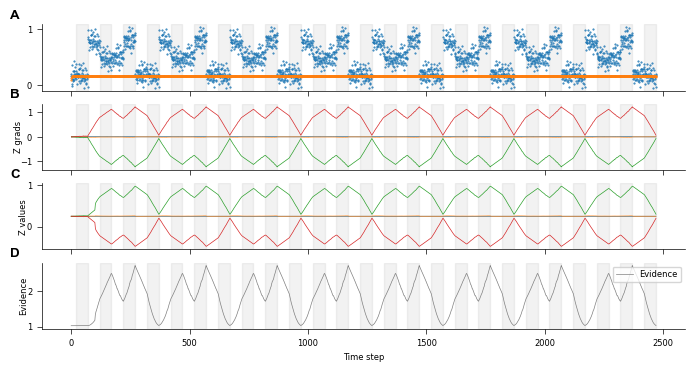

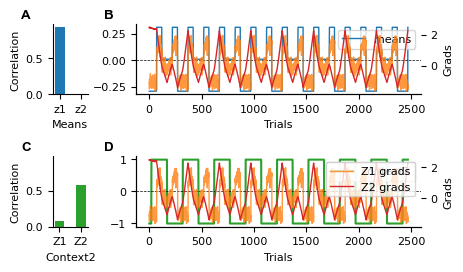

In [4]:
config.training_phases[0]['config']['no_of_blocks'] = 50
testing_env = Generative_environment(config, experiment=experiment)

if horizon_long_short == 'long':
        horizon = int(training_phase_1_config['max_trials_per_block'] * (1+1))
else:
        horizon = 5
optimizer = 'LU'
logger = Logger(config)
criterion = nn.MSELoss(reduction='sum')
_use_optimized_thalamus = False
config.backprop_only_last_timestep = False
config.accummulate_thalamus_temporally = True

testing_memory_buffer, testing_losses = adapt_model_v3(model, testing_env, _use_oracle, config, optimizer, horizon, criterion,
                                                0, logger, _use_optimized_thalamus=_use_optimized_thalamus,)
plot_grads(testing_memory_buffer, testing_env, x1=50, x2=np.inf)
prespecified_thalamus_untrained = np.stack(testing_memory_buffer.timestep_data['thalamus'])
# plot_modulations(testing_memory_buffer, testing_env, testing_losses, config, x1=50, x2=np.inf, latent_dim = 0)
# plot_modulations(testing_memory_buffer, testing_env, testing_losses, config, x1=50, x2=np.inf, latent_dim = 1)
# plot_task_and_hierarchies_illustration(testing_memory_buffer, testing_env, testing_losses, config,  )
# from plot_functions import plot_dual_modulations
plot_dual_modulations(testing_memory_buffer, testing_env, testing_losses, config, x1=50, x2=np.inf)
# (testing_memory_buffer, testing_env, testing_losses, config, x1=50, x2=np.inf, latent_dim = 0)
# plot_modulations(testing_memory_buffer, testing_env, testing_losses, config, x1=50, x2=np.inf, latent_dim = 1)

Process the thalamus, or thalamus grads to use as a latent input

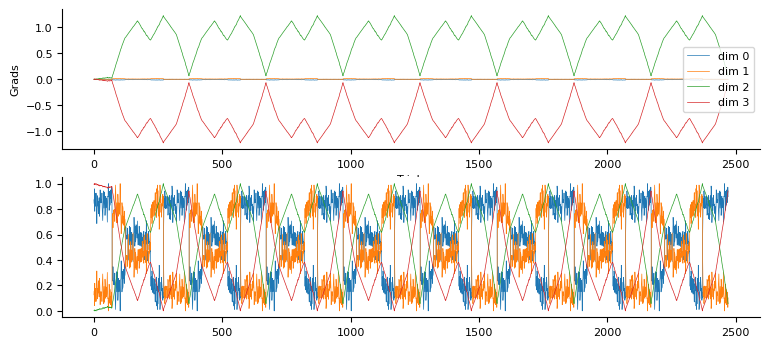

In [5]:
# plot prespecified_thalamus 
prespecified_thalamus = -np.stack(testing_memory_buffer.timestep_data['thalamus_grad'])
# print('shape of prespecified_thalamus: ', prespecified_thalamus.shape)
prespecified_thalamus[0] = 0 # first value is padded with a nan
# prespecified_thalamus = np.stack(testing_memory_buffer.timestep_data['thalamus'])
fig, axes = plt.subplots(2,1, figsize=(9,4))
ax = axes[0]
for dim in range(prespecified_thalamus.shape[-1]):
        ax.plot(prespecified_thalamus.squeeze()[:,dim], label=f'dim {dim}', linewidth=0.5)
ax.set_ylabel('Grads')
ax.set_xlabel('Trials')
ax.legend()
prespecified_thalamus = prespecified_thalamus / ((np.std(prespecified_thalamus, axis=0, keepdims=True))) 
prespecified_thalamus = (prespecified_thalamus - np.min(prespecified_thalamus, axis=0, keepdims=True))/ np.ptp(prespecified_thalamus, axis=0, keepdims=True)

ax = axes[1]
ax.plot(prespecified_thalamus.squeeze()[:,], linewidth=0.5)

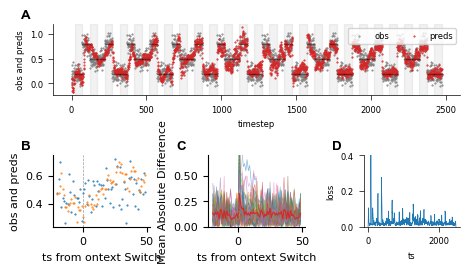

In [11]:
### NEW MODEL
use_prespecified_thalamus = True
horizon = 5
config.thalamus_activation_function = 'none' # important, otherwise will collapse information in the prespecified thalamus by softmax down some weird dim
_use_oracle = False
input_distort = False
model_ali = LSTM_model(config,hidden_size=100)
env = Generative_environment(config, experiment=experiment) # the same env with the same config.seed, so the data will be the same
logger = Logger(config) # clear the logger
memory_buffer, losses = adapt_model_v3(model_ali, env, _use_oracle, config, 'WU', horizon, nn.MSELoss(), 0, logger,
        prespecified_thalamus=prespecified_thalamus if use_prespecified_thalamus else None, input_distort=input_distort)
plot_behavior(memory_buffer, env, losses, config, _use_oracle,)
_use_oracle = False


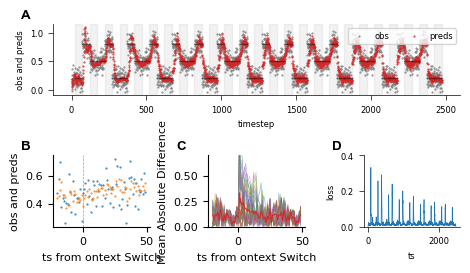

In [7]:
### NEW MODEL
use_prespecified_thalamus = False
model_vanilla = LSTM_model(config,hidden_size=100)
env = Generative_environment(config, experiment=experiment) # the same env with the same config.seed, so the data will be the same
logger = Logger(config) # clear the logger
memory_buffer, losses = adapt_model_v3(model_vanilla, env, _use_oracle, config, 'WU', horizon, nn.MSELoss(), 0, logger,
        prespecified_thalamus=prespecified_thalamus if use_prespecified_thalamus else None, input_distort=input_distort)
plot_behavior(memory_buffer, env, losses, config, _use_oracle,)